# Importing relevant things

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
from torch import nn, optim
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Subset, TensorDataset
import os
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
import torch.nn.functional as F
from sklearn import metrics
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment
from pytorch_msssim import SSIM
from dataset import *
from device_data_loader import *
from loss import *
from model import *
from params import *
from plot import *
from rcc_trainer import *
from ucc_trainer import *


# Loading the dataset

In [3]:
splitted_dataset = np.load("../Dataset/splitted_cifar10_dataset.npz")

x_train = splitted_dataset['x_train']
print(f"x_train shape :{x_train.shape}")

y_train = splitted_dataset['y_train']
print(f"y_train shape :{y_train.shape}")

x_val = splitted_dataset['x_val']
print(f"x_val shape :{x_val.shape}")

y_val = splitted_dataset['y_val']
print(f"y_val shape :{y_val.shape}")

x_test = splitted_dataset['x_test']
print(f"x_test shape :{x_test.shape}")

y_test = splitted_dataset['y_test']
print(f"y_test shape: {y_test.shape}")


x_train shape :(40000, 32, 32, 3)
y_train shape :(40000, 1)
x_val shape :(10000, 32, 32, 3)
y_val shape :(10000, 1)
x_test shape :(10000, 32, 32, 3)
y_test shape: (10000, 1)


## Creating the dataset object

In [9]:
dataset = Dataset(x_train, y_train, x_val, y_val, x_test, y_test, debug=False, apply_augmentation=True)

Converted numpy to torch tensors
Creating KDE dataloaders


10it [00:00, 50.88it/s]


Finished constructing the kde_datasets from the test dataset, now creating dataloaders
Created KDE dataloaders, now creating autoencoder dataloaders
Created autoencoder dataloaders, now creating ucc dataloaders


100%|██████████| 833/833 [00:00<00:00, 4927.45it/s]


Created ucc dataloaders, now creating rcc dataloaders


100%|██████████| 833/833 [00:00<00:00, 5893.09it/s]


Initilized all dataloaders


# Checking how one bag looks like

Checking out train


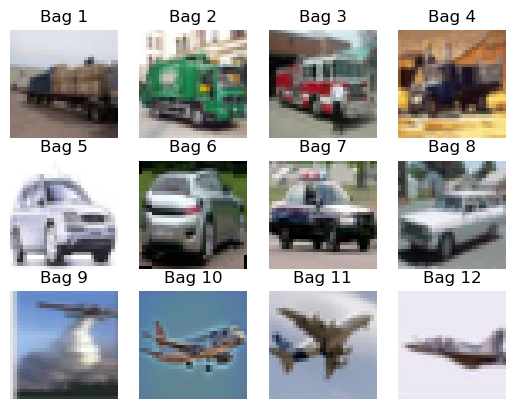

Checking out test


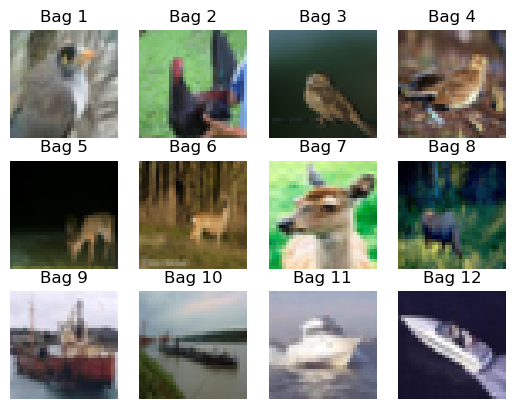

Checking out val


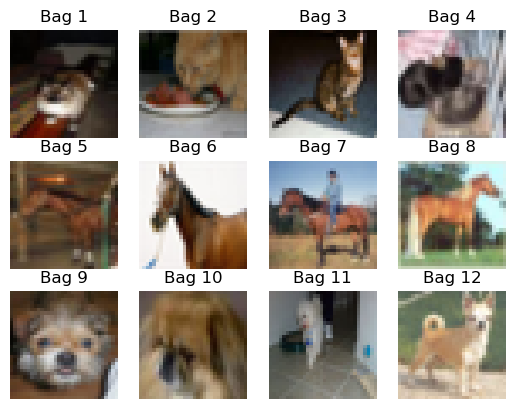

In [10]:
#printing the images in a bag 
import matplotlib.pyplot as plt

tensor_to_img_transform = transforms.ToPILImage()
dataloaders = [dataset.ucc_train_dataloader, dataset.ucc_test_dataloader, dataset.ucc_val_dataloader]
names = ["train", "test", "val"]
# params = {
#     "train":[dataset.train_mu, dataset.train_std],
#     "test": [dataset.test_mu, dataset.test_std],
#     "val": [dataset.val_mu, dataset.val_std]
# }

for ucc_dataloader, name in zip(dataloaders, names):
    print(f"Checking out {name}")
    for data in ucc_dataloader:
        batches, _ = data
        for bag in batches:
            for image_index, image in enumerate(bag):
                # image *= 255
                image = tensor_to_img_transform(image)
                plt.subplot(3, 4, image_index + 1)  # Assuming 12 images per bag
                plt.imshow(image)  # Display the image
                plt.title(f"Bag {image_index + 1}")  # Set the title
                plt.axis('off')  # Turn off axis labels
            plt.show()
            break
        break
plt.show()



## Define the class names

In [11]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]


# EXPERIMENT-1 : UCC Model

This model tries to replicate the paper where we have an autoencoder path and a ucc path.

Similarly experiment-2 will be the improvement model

## Creating the model instances


In [12]:
experiment1 = "ucc"
save_dir = os.path.abspath(config.weights_path)
autoencoder_ucc_model = Autoencoder().to(config.device)
ucc_predictor_model = UCCPredictor().to(config.device)

#creating the trainer
ucc_trainer = UCCTrainer(experiment1, autoencoder_ucc_model, ucc_predictor_model, dataset, save_dir)

Autoencoder model initialized!


## Training the model

Total Epochs: 0.0% |          | 0/2 [00:00<?, ?it/s]

Epoch 1/2:   0%|          | 0/3333 [00:00<?, ?it/s]

Finished computing val stats, now showing a sample reconstruction
Got a sample reconstruction, now trying to reshape in order to show an example
Reshaped the original image into bag format


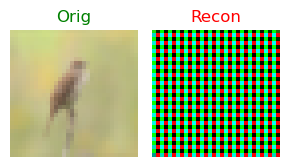

# Epoch 1
[TRAIN]: Epoch Loss: 1.4280576973286185 | AE Loss: 0.011804266588272291 | UCC Loss: 1.4162534263232003 | UCC Acc: 0.24242424242424243
[VAL]: Val Loss: 1.400309096722185 | Val AE Loss: 0.014014724637566207 | Val UCC Loss: 1.3862943649291992 | Val UCC Acc: 0.25090036014405764
------------------------------------------------------------


Epoch 2/2:   0%|          | 0/3333 [00:00<?, ?it/s]

Finished computing val stats, now showing a sample reconstruction
Got a sample reconstruction, now trying to reshape in order to show an example
Reshaped the original image into bag format


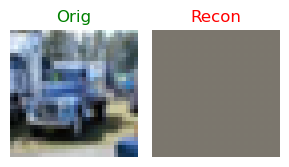

# Epoch 2
[TRAIN]: Epoch Loss: 1.395698492622862 | AE Loss: 0.007121670453569176 | UCC Loss: 1.3885768164287915 | UCC Acc: 0.24842484248424843
[VAL]: Val Loss: 1.3924160797913678 | Val AE Loss: 0.00612171178533822 | Val UCC Loss: 1.3862943649291992 | Val UCC Acc: 0.25090036014405764
------------------------------------------------------------


In [13]:
exp1_epoch_numbers, exp1_training_ae_losses, exp1_training_ucc_losses, exp1_training_losses, exp1_training_ucc_accuracies, exp1_val_ae_losses, exp1_val_ucc_losses, exp1_val_losses, exp1_val_ucc_accuracies = ucc_trainer.train(2, epoch_saver_count=6)

|## Additional Training if required

In [9]:
# exp1_epoch_numbers, exp1_training_ae_losses, exp1_training_ucc_losses, exp1_training_losses, exp1_training_ucc_accuracies, exp1_val_ae_losses, exp1_val_ucc_losses, exp1_val_losses, exp1_val_ucc_accuracies = ucc_trainer.train(10, epoch_saver_count=2, load_from_checkpoint=True, resume_epoch_num=42)

## Plotting the model stats

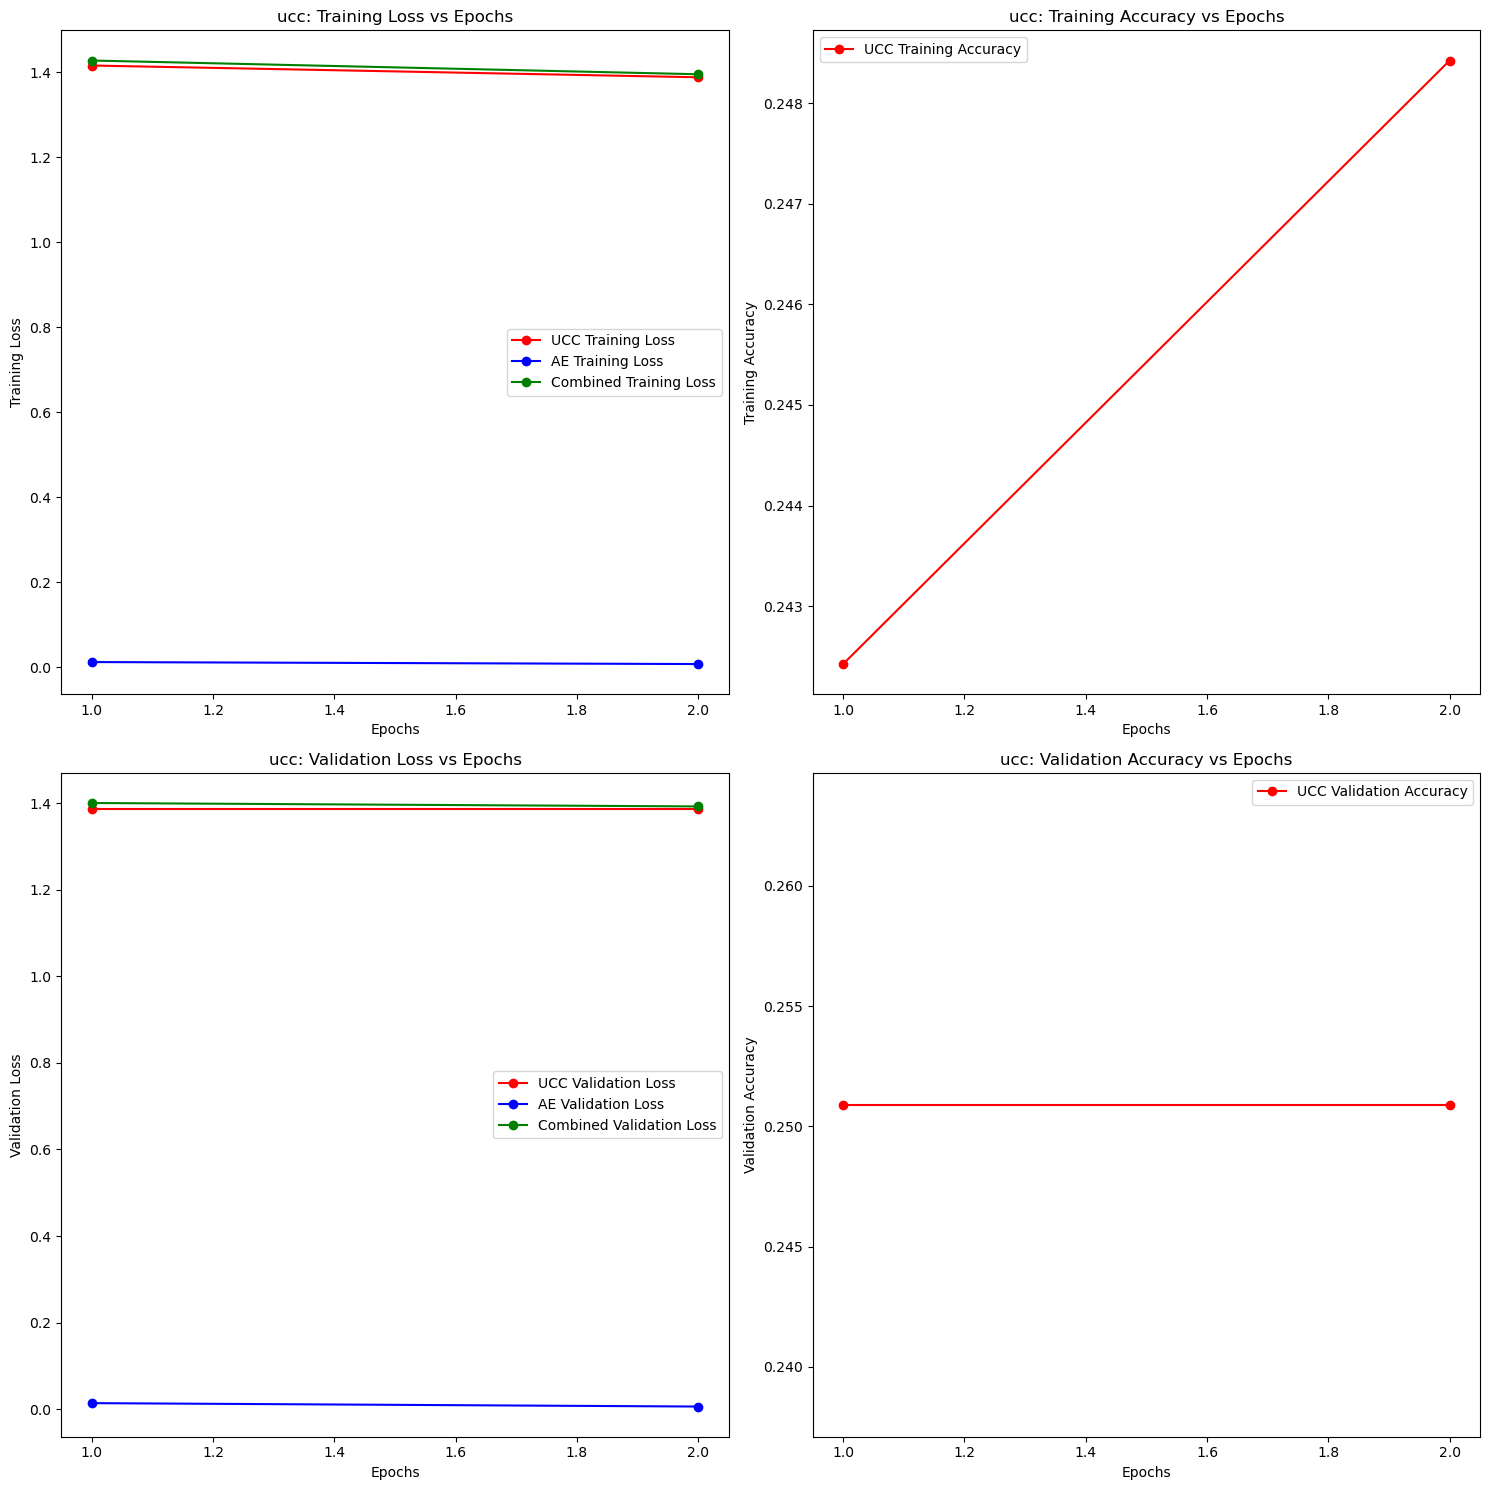

In [14]:
plot_ucc_model_stats(experiment1, exp1_epoch_numbers, exp1_training_ucc_losses, exp1_training_ae_losses, exp1_training_losses,
                     exp1_training_ucc_accuracies, exp1_val_ucc_losses, exp1_val_ae_losses, exp1_val_losses,
                     exp1_val_ucc_accuracies)

## Testing the model

Got a sample reconstruction, now trying to reshape in order to show an example
Reshaped the original image into bag format


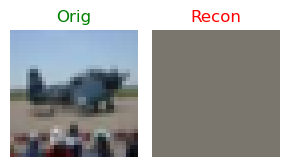

{'avg_test_loss': 1.392363134981776,
 'avg_test_ae_loss': 0.006068762324723591,
 'avg_test_ucc_loss': 1.3862943649291992,
 'avg_test_ucc_training_accuracy': 0.25090036014405764}

In [17]:
ucc_trainer.test_model()

## Calculating the Min JS Divergence

In [15]:
exp1_min_js_divg = ucc_trainer.calculate_min_js_divergence()
exp1_min_js_divg

0it [00:00, ?it/s]

JS Divergence between 0 & 1 is 0.0
JS Divergence between 0 & 2 is 0.0
JS Divergence between 0 & 3 is 0.0
JS Divergence between 0 & 4 is 0.0
JS Divergence between 0 & 5 is 0.0
JS Divergence between 0 & 6 is 0.0
JS Divergence between 0 & 7 is 0.0
JS Divergence between 0 & 8 is 0.0
JS Divergence between 0 & 9 is 0.0
JS Divergence between 1 & 2 is 0.0
JS Divergence between 1 & 3 is 0.0
JS Divergence between 1 & 4 is 0.0
JS Divergence between 1 & 5 is 0.0
JS Divergence between 1 & 6 is 0.0
JS Divergence between 1 & 7 is 0.0
JS Divergence between 1 & 8 is 0.0
JS Divergence between 1 & 9 is 0.0
JS Divergence between 2 & 3 is 0.0
JS Divergence between 2 & 4 is 0.0
JS Divergence between 2 & 5 is 0.0
JS Divergence between 2 & 6 is 0.0
JS Divergence between 2 & 7 is 0.0
JS Divergence between 2 & 8 is 0.0
JS Divergence between 2 & 9 is 0.0
JS Divergence between 3 & 4 is 0.0
JS Divergence between 3 & 5 is 0.0
JS Divergence between 3 & 6 is 0.0
JS Divergence between 3 & 7 is 0.0
JS Divergence betwee

tensor(0., device='cuda:0', grad_fn=<MulBackward0>)

## Calculating the Clustering Accuracy

In [16]:
exp1_clustering_accuracies = ucc_trainer.calculate_clustering_accuracy()
exp1_clustering_accuracies

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Got the latent features for all test images, now doing Kmeans
Got the kmeans predicted labels, now computing clustering accuracy


C:\Parashara\Projects\NUS projects\Sem1\Assignments\NUS-CS5242-Neural-Networks-and-Deep-Learning\Assignment 3 (CIFAR Clustering)\My test code\ucc_trainer.py:614: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  estimator.fit(all_latent_features)


0.1

In [ ]:
#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------#

# EXPERIMENT-2 : UCC-RCC Model

This model is an improvement to the original model as we are also trying to predict the RCC (Real Class Counts) as a separate multitask path. This approach in theory should improve the accuracy of the model.

Additionally we use the SSIM loss for the autoencoder as that is known to be a good loss function when it comes to autoencoders.



## Creating the model instances


In [ ]:
experiment2 = "ucc-rcc"
save_dir = os.path.abspath(config.weights_path)
autoencoder_ucc_model = Autoencoder().to(config.device)
ucc_predictor_model = UCCPredictor().to(config.device)
rcc_predictor_model = RCCPredictor().to(config.device)

#creating the trainer
rcc_trainer = RCCTrainer(experiment2, autoencoder_ucc_model, ucc_predictor_model, rcc_predictor_model, dataset, save_dir)

## Training the model

In [ ]:
exp2_epoch_numbers, exp2_training_ae_losses, exp2_training_ucc_losses, exp2_training_rcc_losses, exp2_training_losses, exp2_training_ucc_accuracies, exp2_training_rcc_accuracies, exp2_val_ae_losses, exp2_val_ucc_losses, exp2_val_rcc_losses, exp2_val_losses, exp2_val_ucc_accuracies, exp2_val_rcc_accuracies = rcc_trainer.train(1, epoch_saver_count=1)

## Additional Training if required


In [ ]:
 # exp2_epoch_numbers, exp2_training_ae_losses, exp2_training_ucc_losses, exp2_training_rcc_losses, exp2_training_losses, exp2_training_ucc_accuracies, exp2_training_rcc_accuracies, exp2_val_ae_losses, exp2_val_ucc_losses, exp2_val_rcc_losses, exp2_val_losses, exp2_val_ucc_accuracies, exp2_val_rcc_accuracies = rcc_trainer.train(10, epoch_saver_count=2, load_from_checkpoint=True, resume_epoch_num=42)

## Plotting the model stats

In [ ]:
plot_ucc_rcc_model_stats(experiment2, exp2_epoch_numbers, exp2_training_ucc_losses, exp2_training_ae_losses,
                         exp2_training_rcc_losses, exp2_training_losses, exp2_training_ucc_accuracies,
                         exp2_training_rcc_accuracies, exp2_val_ucc_losses, exp2_val_ae_losses, exp2_val_rcc_losses,
                         exp2_val_losses, exp2_val_ucc_accuracies, exp2_val_rcc_accuracies)

## Testing the model

In [ ]:
rcc_trainer.test_model()

## Calculating the Min JS Divergence

In [ ]:
exp2_min_js_divg = rcc_trainer.calculate_min_js_divergence()
exp2_min_js_divg

## Calculating the Clustering Accuracy

In [ ]:
exp2_clustering_accuracies = rcc_trainer.calculate_clustering_accuracy()
exp2_clustering_accuracies